<a href="https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/7_GradientNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Import libraries**

In [1]:
import random
import matplotlib.pyplot as plt # truc quan hoa
import numpy as np

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import FashionMNIST #download fashion mnist data


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

SEED = 42
set_seed(SEED)

cuda


## **1. Prepare dataset**


In [3]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.4MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [9]:
train_ratio = 0.9
train_size = int(train_ratio * len(train_dataset)) #90%
val_size = len(train_dataset) - train_size #10%

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 512
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Validation size: 6000
Test size: 10000


## **2. Build MLP network `with Gradient Norm`**




In [5]:
# Custom Gradient Normalization Layer
# Use Pytorch's autograd mechanism to normalize gradients during backpropagation phase
class GradientNormalization(torch.autograd.Function):
  @staticmethod
  def forward(ctx, input):
    # Forward pass: pass input unchanged
    ctx.save_for_backward(input)
    return input

  @staticmethod
  def backward(ctx, grad_output):
    # Normalize the gradient
    mean = torch.mean(grad_output)
    std = torch.std(grad_output)
    avoid_division_by_zero = 1e-6
    grad_input = (grad_output - mean) / (std + avoid_division_by_zero)
    return grad_input

# Wrapper Module for GradientNormalization
class GradientNormalizationLayer(nn.Module):
  def __init__(self):
    super(GradientNormalizationLayer, self).__init__()

  def forward(self, x):
    return GradientNormalization.apply(x)

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        out = self.output(x)
        return out

In [7]:
input_dims = 784 #28x28 pixel = 784 pixel
hidden_dims = 128
output_dims = 10 #10 class
lr = 1e-2
model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## **3. Training**

In [10]:
epochs = 100
train_loss_lst =[]
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
  train_loss = 0
  train_acc = 0
  count = 0
  model.train()
  for X_train, y_train in train_loader:
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc += (torch.argmax(outputs,1) == y_train).sum().item()
    count += len(y_train)
  train_loss /= len(train_loader)
  train_loss_lst.append(train_loss)
  train_acc /= count
  train_acc_lst.append(train_acc)

  val_loss = 0.0
  val_acc = 0.0
  count = 0
  model.eval()
  with torch.no_grad():
    for X_val, y_val in val_loader:
      X_val = X_val.to(device)
      y_val = y_val.to(device)
      outputs = model(X_val)
      loss = criterion(outputs, y_val)
      val_loss += loss.item()
      val_acc += (torch.argmax(outputs,1) == y_val).sum().item()
      count += len(y_val)
  val_loss /= len(val_loader)
  val_loss_lst.append(val_loss)
  val_acc /= count
  val_acc_lst.append(val_acc)

  print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f},Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f} , Val_Acc:{val_acc:.4f}")

EPOCH 1/100, Train_Loss: 0.7190,Train_Acc: 0.7431, Validation Loss: 0.6077 , Val_Acc:0.8035
EPOCH 2/100, Train_Loss: 0.6736,Train_Acc: 0.7709, Validation Loss: 0.6394 , Val_Acc:0.8158
EPOCH 3/100, Train_Loss: 0.7175,Train_Acc: 0.7779, Validation Loss: 0.8103 , Val_Acc:0.7325
EPOCH 4/100, Train_Loss: 0.6887,Train_Acc: 0.7711, Validation Loss: 0.6130 , Val_Acc:0.8167
EPOCH 5/100, Train_Loss: 0.7125,Train_Acc: 0.7533, Validation Loss: 0.6759 , Val_Acc:0.8132
EPOCH 6/100, Train_Loss: 0.6910,Train_Acc: 0.7662, Validation Loss: 0.7006 , Val_Acc:0.7178
EPOCH 7/100, Train_Loss: 0.7343,Train_Acc: 0.7283, Validation Loss: 0.8133 , Val_Acc:0.7207
EPOCH 8/100, Train_Loss: 0.7345,Train_Acc: 0.7601, Validation Loss: 0.7378 , Val_Acc:0.7253
EPOCH 9/100, Train_Loss: 0.6723,Train_Acc: 0.7714, Validation Loss: 0.6107 , Val_Acc:0.8192
EPOCH 10/100, Train_Loss: 0.6593,Train_Acc: 0.7901, Validation Loss: 0.6086 , Val_Acc:0.8060
EPOCH 11/100, Train_Loss: 0.6345,Train_Acc: 0.7935, Validation Loss: 0.6225 , V

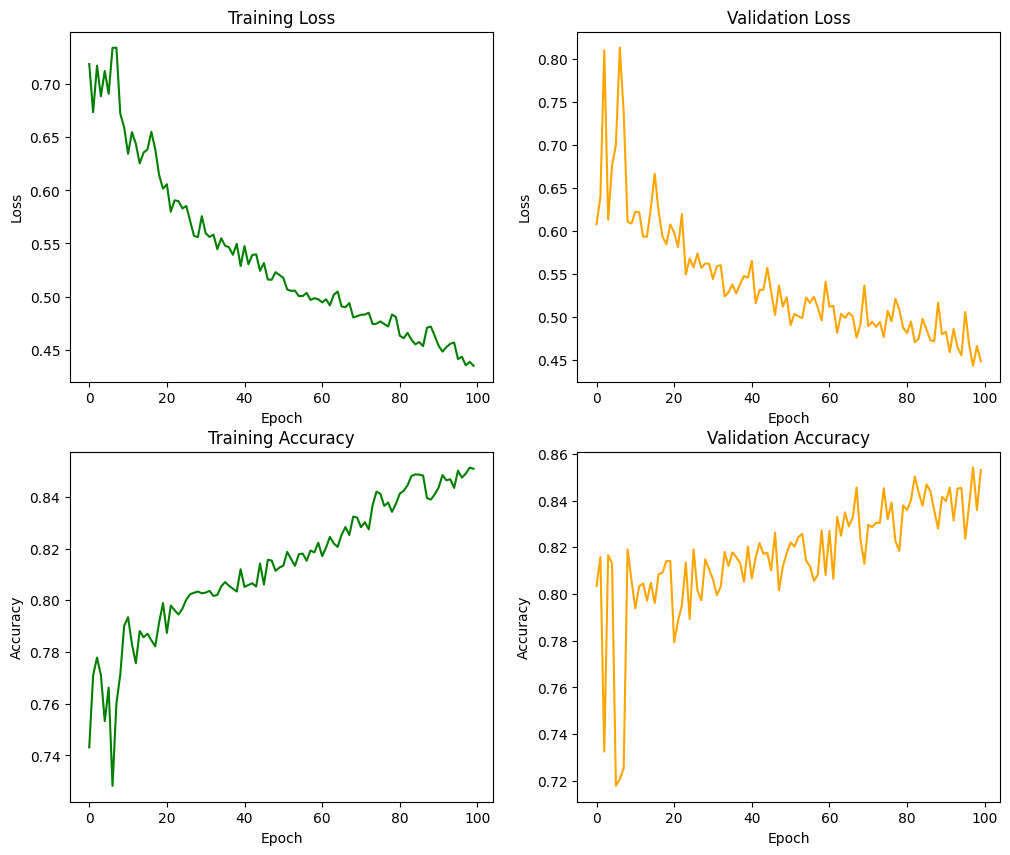

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **4. Evaluation**

In [12]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    outputs = model(X_test)

    test_target.append(y_test.cpu())
    test_predict.append(outputs.cpu())

test_target = torch.cat(test_target, dim=0) #ghép theo chiều thứ nhất chiều batch(chiều dọc)
test_predict = torch.cat(test_predict, dim=0)

test_acc = (torch.argmax(test_predict,1)==test_target).sum().item()/len(test_target)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8355


In [13]:
val_label = []
val_predict = []

model.eval()
with torch.no_grad():
  for X_val, y_val in val_loader:
    X_val, y_val = X_val.to(device), y_val.to(device)

    output = model(X_val)

    val_label.append(y_val.cpu())
    val_predict.append(output.cpu())

  val_label = torch.cat(val_label, dim=0)
  val_predict = torch.cat(val_predict, dim=0)
  val_acc = (torch.argmax(val_predict, dim=1) == val_label).sum().item()/len(val_label)

print(f"Validation accuracy: {val_acc:.4f}")

Validation accuracy: 0.8532
